In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# параметры распределений
mu0_x, mu0_y = (0.1, 0.3) 
mu0 = torch.tensor([mu0_x, mu0_y])
sigma0 = 0.15
covar0 = torch.eye(2) * sigma0

mu1_x, mu1_y = (0.9, 0.7) 
mu1 = torch.tensor([mu1_x, mu1_y])
sigma1 = 0.25
covar1 = torch.eye(2) * sigma1

In [3]:
covar0

tensor([[0.1500, 0.0000],
        [0.0000, 0.1500]])

In [4]:
d0 = torch.distributions.MultivariateNormal(mu0, covariance_matrix=covar0)
d1 = torch.distributions.MultivariateNormal(mu1, covariance_matrix=covar1)

In [5]:
def sample(d0, d1, n=32):
    x0 = d0.sample((n,))
    x1 = d1.sample((n,))
    y0 = torch.zeros((n, 1))
    y1 = torch.ones((n, 1))
    return torch.cat([x0, x1], 0), torch.cat([y0, y1], 0)

In [6]:
d0_sample = d0.sample((128,))
d1_sample = d1.sample((128,))

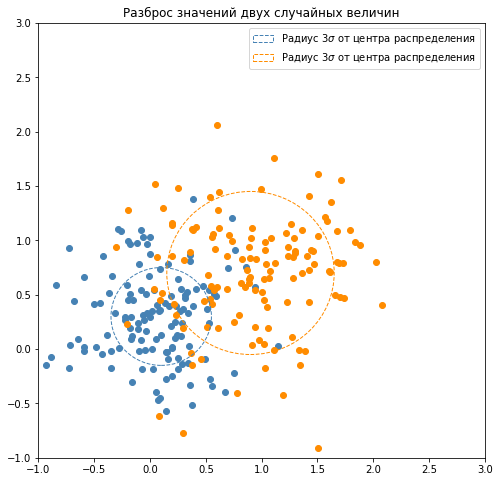

In [7]:
d0_sample_x = d0_sample[:,0].tolist()
d0_sample_y = d0_sample[:,1].tolist()
d1_sample_x = d1_sample[:,0].tolist()
d1_sample_y = d1_sample[:,1].tolist()

fig, ax = plt.subplots(figsize=(8,8))

ax.add_patch(plt.Circle((mu0_x, mu0_y), radius=3*sigma0, color='steelblue', fill=False, ls='dashed', label=r'Радиус $3\sigma $ от центра распределения'))
ax.add_patch(plt.Circle((mu1_x, mu1_y), radius=3*sigma1, color='darkorange', fill=False, ls='dashed', label=r'Радиус $3\sigma $ от центра распределения'))
ax.scatter(d0_sample_x, d0_sample_y, color='steelblue');
ax.scatter(d1_sample_x, d1_sample_y, color='darkorange');

ax.set_xlim(-1,3);
ax.set_ylim(-1,3);

ax.legend()

ax.set_title('Разброс значений двух случайных величин', fontsize=12);

In [8]:
layer = nn.Linear(2, 1)
print([p.data[0] for p in layer.parameters()])
layer_opt = optim.SGD(lr=2e-3, params=list(layer.parameters()))

[tensor([-0.5545, -0.2177]), tensor(-0.1255)]


In [9]:
log_freq = 2500
for i in range(50000):
    if i%log_freq == 0:
        with torch.no_grad():
            x, y = sample(d0, d1, 100000)
            out = torch.sigmoid(layer(x))
            loss = F.binary_cross_entropy(out, y)
        print('Ошибка после %d итераций: %f' %(i/log_freq, loss))
    layer_opt.zero_grad()
    x, y = sample(d0, d1, 1024)
    out = torch.sigmoid(layer(x))
    loss = F.binary_cross_entropy(out, y)
    loss.backward()
    layer_opt.step()

Ошибка после 0 итераций: 0.874186
Ошибка после 1 итераций: 0.599449
Ошибка после 2 итераций: 0.518487
Ошибка после 3 итераций: 0.473948
Ошибка после 4 итераций: 0.444039
Ошибка после 5 итераций: 0.425040
Ошибка после 6 итераций: 0.409169
Ошибка после 7 итераций: 0.400959
Ошибка после 8 итераций: 0.391496
Ошибка после 9 итераций: 0.386321
Ошибка после 10 итераций: 0.380735
Ошибка после 11 итераций: 0.378379
Ошибка после 12 итераций: 0.373487
Ошибка после 13 итераций: 0.370574
Ошибка после 14 итераций: 0.368155
Ошибка после 15 итераций: 0.366898
Ошибка после 16 итераций: 0.366811
Ошибка после 17 итераций: 0.363967
Ошибка после 18 итераций: 0.363135
Ошибка после 19 итераций: 0.362721


#### Веса $w_0, w_1$ и смещение $b$ слоя layer

In [10]:
print([p.data[0].numpy() for p in layer.parameters()])

[array([3.287686 , 1.5356395], dtype=float32), array(-2.2562551, dtype=float32)]


In [11]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import expit
from matplotlib import cm

In [12]:
x_range = np.linspace(-1, 3, num=41)
y_range = np.linspace(-1, 3, num=41)
x_scale, y_scale = np.meshgrid(x_range, y_range)
xy_scale=np.dstack((x_scale, y_scale))
d0_pdf = stats.multivariate_normal.pdf(xy_scale, [mu0_x, mu0_y], cov=np.eye(2)*sigma0) 
d1_pdf = stats.multivariate_normal.pdf(xy_scale, [mu1_x, mu1_y], cov=np.eye(2)*sigma1)
x_tensor = torch.tensor(xy_scale.reshape(-1, 2), dtype=torch.float)
with torch.no_grad():
    dist = torch.sigmoid(layer(x_tensor)).numpy()

In [13]:
mu0_x_range = np.ones(41)*mu0_x
mu1_x_range = np.ones(41)*mu1_x
mu0_y_range = np.ones(41)*mu0_y
mu1_y_range = np.ones(41)*mu1_y

k_centers = (mu1_y - mu0_y) / (mu1_x - mu0_x)
b_centers = mu1_y - k_centers * mu1_x

y_centers_range = k_centers*x_range + b_centers

x_proj_0 = stats.multivariate_normal.pdf(np.dstack((mu0_x_range, y_range)), [mu0_x, mu0_y], cov=np.eye(2)*sigma0)
x_proj_1 = stats.multivariate_normal.pdf(np.dstack((mu1_x_range, y_range)), [mu1_x, mu1_y], cov=np.eye(2)*sigma1)

y_proj_0 = stats.multivariate_normal.pdf(np.dstack((x_range, mu0_y_range)), [mu0_x, mu0_y], cov=np.eye(2)*sigma0)
y_proj_1 = stats.multivariate_normal.pdf(np.dstack((x_range, mu1_y_range)), [mu1_x, mu1_y], cov=np.eye(2)*sigma1)

tensor_W, tensor_b = [p.data[0] for p in layer.parameters()]
w0, w1 = tensor_W.numpy().tolist()
b = tensor_b.item()

x_proj_sigmoid = expit(w0*x_range + w1*y_centers_range + b)
y_proj_sigmoid = expit(w0*x_range + w1*y_centers_range + b)

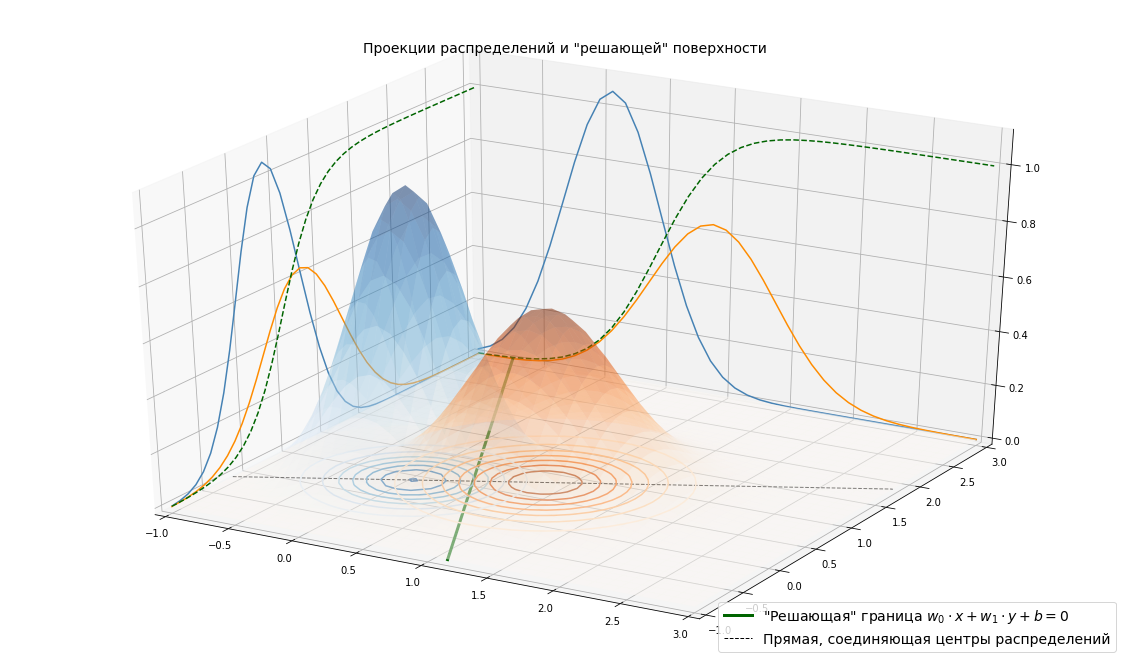

In [14]:
fig = plt.figure(figsize=(20,12))

ax = fig.gca(projection='3d')

ax.contour(x_scale, y_scale, d0_pdf, zdir='z', offset=0, cmap=cm.Blues)
ax.plot_surface(x_scale, y_scale, d0_pdf, alpha=0.3, cmap=cm.Blues)
ax.plot(xs=y_range, ys=x_proj_0, zs=-1, zdir='x', color='steelblue')
ax.plot(xs=x_range, ys=y_proj_0, zs=3, zdir='y', color='steelblue')

ax.contour(x_scale, y_scale, d1_pdf, zdir='z', offset=0, cmap=cm.Oranges)
ax.plot_surface(x_scale, y_scale, d1_pdf, alpha=0.3, cmap=cm.Oranges)
ax.plot(xs=y_range, ys=x_proj_1, zs=-1, zdir='x', color='darkorange')
ax.plot(xs=x_range, ys=y_proj_1, zs=3, zdir='y', color='darkorange')

ax.plot(
    xs=-(y_range * w1 + b)/w0,
    ys=y_range,
    zs=0, zdir='z', color='darkgreen', lw=3, ls='-', label=r'"Решающая" граница $w_0\cdot x + w_1\cdot y + b = 0$'
)

ax.plot(
    xs=x_range,
    ys=k_centers*x_range + b_centers,
    zs=0, zdir='z', color='black', ls='--', lw=1, label='Прямая, соединяющая центры распределений'
)
ax.plot(xs=y_range, ys=x_proj_sigmoid, zs=-1, zdir='x', color='darkgreen', ls='--')
ax.plot(xs=x_range, ys=y_proj_sigmoid, zs=3, zdir='y', color='darkgreen', ls='--')

ax.set_xlim(-1,3);
ax.set_ylim(-1,3);
ax.set_zlim(0,1.1);
ax.set_title('Проекции распределений и "решающей" поверхности', fontsize=14);
ax.legend(fontsize=14, loc='lower right');

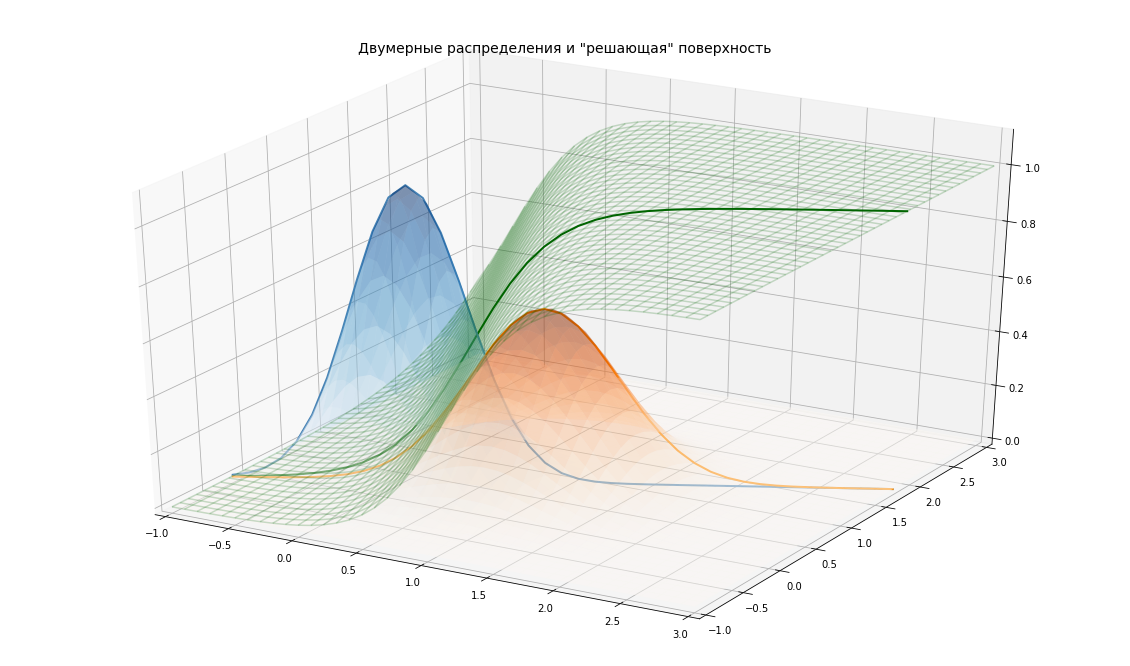

In [15]:
fig = plt.figure(figsize=(20,12))

ax = fig.gca(projection='3d')

ax.plot_wireframe(x_scale, y_scale, dist.reshape(41,41), alpha=0.2, color='darkgreen')

ax.plot_surface(x_scale, y_scale, d0_pdf, alpha=0.3, cmap=cm.Blues)

ax.plot_surface(x_scale, y_scale, d1_pdf, alpha=0.3, cmap=cm.Oranges)

ax.plot(
    xs=x_range,
    ys=k_centers*x_range + b_centers,
    zs=expit(w0*x_range + w1*(k_centers*x_range + b_centers) + b),
    color='darkgreen', ls='-', lw=2
)
ax.plot(
    xs=x_range,
    ys=y_centers_range,
    zs=stats.multivariate_normal.pdf(np.dstack((x_range, y_centers_range)), [mu0_x, mu0_y], cov=np.eye(2)*sigma0),
    color='steelblue', ls='-', lw=2
)
ax.plot(
    xs=x_range,
    ys=y_centers_range,
    zs=stats.multivariate_normal.pdf(np.dstack((x_range, y_centers_range)), [mu1_x, mu1_y], cov=np.eye(2)*sigma1),
    color='darkorange', ls='-', lw=2
)

ax.set_xlim(-1,3);
ax.set_ylim(-1,3);
ax.set_zlim(0,1.1);
ax.set_title('Двумерные распределения и "решающая" поверхность', fontsize=14);